Syed Huma Shah

netid: ss1516

Case assigned: Loan + Defense

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/140m0i-A2nKxFnEPstCNUl_PH0wOplEWb?usp=sharing)

## ⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset
#### 🔍 Scenario

Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

#### 🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

#### 🟦 Defense
Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

In [2]:
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1) Load Adult; convert "?" to NaN
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame.copy()
df = df.replace("?", np.nan)

# 2) Target BEFORE any encoding
y = (df["class"] == ">50K").astype(int)

# 3) Features (drop target & non-predictive weight)
X = df.drop(columns=["class", "fnlwgt"])

# 4) Identify col types
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

# 5) Train/test split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 6) Preprocess + Model
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # keep sparse compatibility
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

model = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=42, class_weight="balanced_subsample"
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", model)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      7431
           1       0.69      0.65      0.67      2338

    accuracy                           0.85      9769
   macro avg       0.79      0.78      0.78      9769
weighted avg       0.84      0.85      0.84      9769



In [4]:
# 🎯 Focus Instance: Loan Rejection Case (Jane Dow)
jane = {
    'age': 37,
    'workclass': 'Private',
    'education': 'Bachelors',
    'marital-status': 'Never-married',
    'occupation': 'Exec-managerial',
    'relationship': 'Not-in-family',
    'race': 'White',
    'sex': 'Female',
    'hours-per-week': 50,
    'native-country': 'United-States',
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}

jane_df = pd.DataFrame([jane])[X.columns]
jane_pred_proba = pipe.predict_proba(jane_df)[0,1]
jane_pred = pipe.predict(jane_df)[0]
print(f"Jane predicted prob(>50K)={jane_pred_proba:.3f} => {'Approved' if jane_pred==1 else 'Denied'}")

Jane predicted prob(>50K)=0.469 => Denied


## Explainable techniques

  0%|          | 0/1 [00:00<?, ?it/s]

Base value (log-odds): -1.1646181212421338


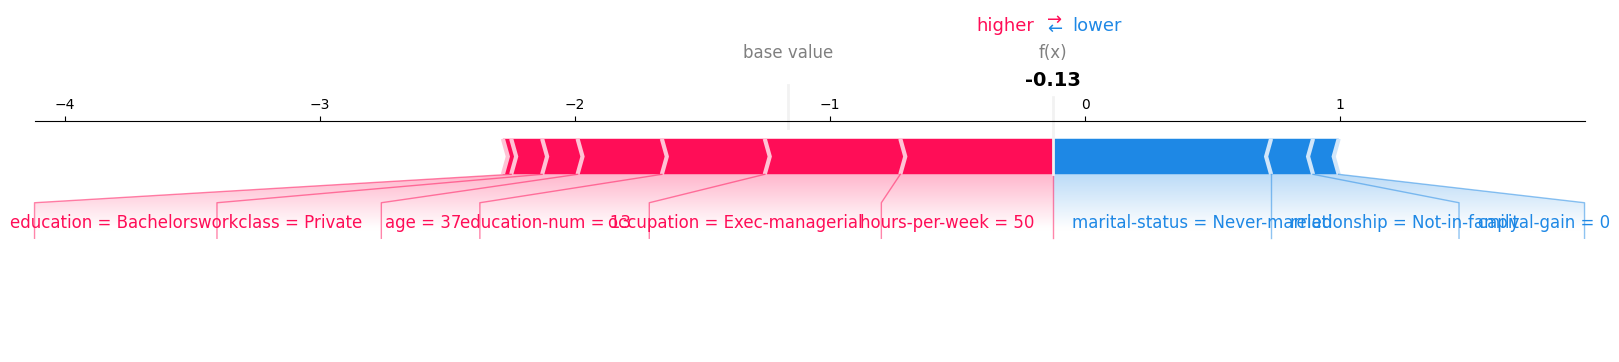

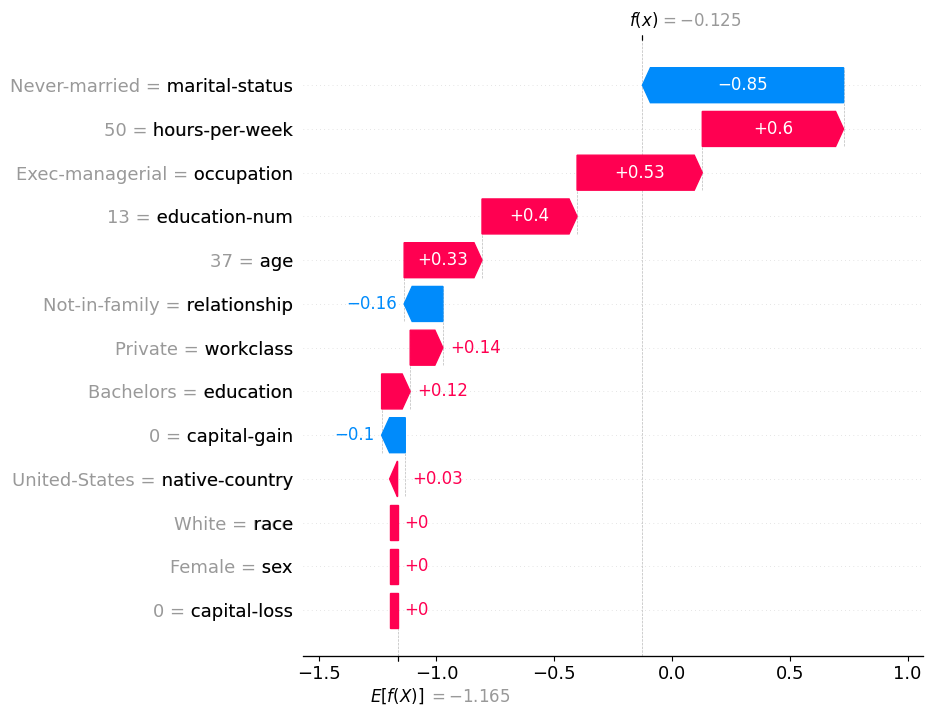

  0%|          | 0/1000 [00:00<?, ?it/s]

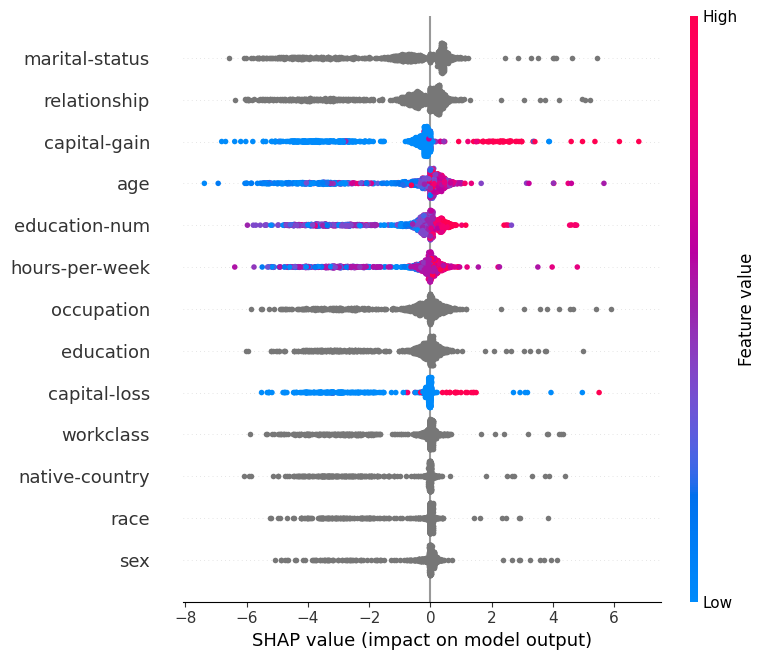

In [13]:
import shap
import numpy as np
import pandas as pd

# 1) Model wrapper stays the same
f = lambda data: pipe.predict_proba(pd.DataFrame(data, columns=X.columns))[:, 1]

# 2) KernelExplainer on raw features
background = X_train.sample(200, random_state=42)
explainer = shap.KernelExplainer(f, background, link="logit")

# 3) Jane local SHAP
shap_values_jane = explainer.shap_values(jane_df, nsamples=200)   # shape: (1, n_features)
base_value = explainer.expected_value                             # scalar (log-odds if link="logit")
print("Base value (log-odds):", base_value)

# 4) Plots (note: no '.values' anywhere)
shap.initjs()

# Force plot (pass 1D array)
shap.force_plot(base_value, shap_values_jane[0], jane_df, matplotlib=True)

# Waterfall: build Explanation with raw numpy arrays
jane_exp = shap.Explanation(
    values=shap_values_jane[0],                 # (n_features,)
    base_values=base_value,                     # scalar
    data=jane_df.iloc[0].values,                # (n_features,)
    feature_names=jane_df.columns.tolist()
)

# Use the new plots API:
shap.plots.waterfall(jane_exp, max_display=15)

# 5) Global view on a sample (beeswarm expects a 2D matrix)
sample = X_test.sample(1000, random_state=0)
shap_values_sample = explainer.shap_values(sample, nsamples=200)  # (m, n_features)
shap.summary_plot(shap_values_sample, sample)                      # beeswarm

## Explanation of SHAP:

1. Jane’s Local Explanation (Force & Waterfall Plots)

	•	The force plot shows how Jane’s features pushed her prediction below the decision threshold (classifying her as ≤$50K).

	•	Positive contributions (red, pushing toward >$50K):

	•	Education = Bachelors and education-num = 13 gave Jane a solid positive push.

	•	Occupation = Exec-managerial and hours-per-week = 50 also increased her income score.

	•	Age = 37 contributed positively as well.

	•	Negative contributions (blue, pushing toward ≤$50K):

	•	Marital-status = Never-married had the strongest negative effect.

	•	Relationship = Not-in-family reinforced this negative influence.

	•	Capital-gain = 0 also lowered her predicted income class.

	•	The model weighed work intensity and education in Jane’s favor, but her lack of capital gains and household structure patterns (single, not-in-family) outweighed these positives.

The decision was not arbitrary—it is grounded in established income-related features. The model is applying consistent logic: individuals with similar education and occupation but without additional income sources (capital gains) or family-based stability are more often classified in the ≤$50K group.


2. Global Explanation (Beeswarm Plot)

	•	Across the test set, the most impactful features are marital-status, relationship, capital-gain, age, education-num, and hours-per-week.

	•	Jane’s case aligns with this: the very same features that drive predictions globally are the ones influencing her local prediction.

	•	Sensitive attributes like race and sex appear at the bottom of the global importance ranking, with minimal SHAP impact.

	•	For Jane specifically, sex (Female) and race (White) had near-zero contribution (as seen in the waterfall plot).

This demonstrates that the model is not relying heavily on protected attributes. Instead, it prioritizes socio-economic indicators directly tied to income.


3. Consistency with Similar Profiles

	•	The SHAP summary distribution shows that capital-gain strongly separates higher-income individuals: people with non-zero capital gains have large positive SHAP values, while those with zero gains (like Jane) consistently get negative pushes.

	•	Likewise, being never-married/not-in-family trends toward lower predicted income, reflecting population-level patterns in the dataset.

Jane’s classification is consistent with how the model treats others in similar circumstances. She is not being singled out unfairly.



In [15]:
# --------- Anchors (compatible with alibi that doesn't accept `categorical_features`) ---------
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from alibi.explainers import AnchorTabular

# Reuse: X, X_train, X_test, cat_cols, num_cols, feature_names, pipe
feature_names = X.columns.tolist()

def normalize_cats(df, cats):
    df = df.copy()
    for c in cats:
        df[c] = df[c].astype(str).str.strip()
    return df

# 1) Normalize categorical text consistently
X_train_norm = normalize_cats(X_train, cat_cols)
X_test_norm  = normalize_cats(X_test,  cat_cols)

# Jane in RAW feature space (same as SHAP)
jane = {
    'age': 37,
    'workclass': 'Private',
    'education': 'Bachelors',
    'marital-status': 'Never-married',
    'occupation': 'Exec-managerial',
    'relationship': 'Not-in-family',
    'race': 'White',
    'sex': 'Female',
    'hours-per-week': 50,
    'native-country': 'United-States',
    'capital-gain': 0,
    'capital-loss': 0,
    'education-num': 13,
}
jane_df   = pd.DataFrame([jane])[feature_names]
jane_norm = normalize_cats(jane_df, cat_cols)

# 2) Fit ONE OrdinalEncoder on the union (train+test+Jane) to avoid unknowns
fit_union = pd.concat([X_train_norm, X_test_norm, jane_norm], axis=0, ignore_index=True)

ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
ord_enc.fit(fit_union[cat_cols])

# Keep label lists for decoding
cat_label_lists = {c: list(ord_enc.categories_[i]) for i, c in enumerate(cat_cols)}

# 3) Numeric frames for Anchors
X_train_num = X_train_norm.copy()
X_train_num[cat_cols] = ord_enc.transform(X_train_norm[cat_cols])

jane_num = jane_norm.copy()
jane_num[cat_cols] = ord_enc.transform(jane_norm[cat_cols])

# 4) categorical_names: {column_index: [labels...]}  (this tells Alibi which columns are categorical)
categorical_names = { feature_names.index(c): cat_label_lists[c] for c in cat_cols }

# 5) Predictor for Anchors: decode ints -> strings, then call your pipeline
def decode_df_from_numeric(X_numeric):
    df = pd.DataFrame(X_numeric, columns=feature_names)
    # decode categoricals
    for c in cat_cols:
        # ensure ints for indexing into label list
        idxs = df[c].astype(int).values
        labels = np.array(cat_label_lists[c], dtype=object)
        df[c] = labels[idxs]
    # ensure numerics stay numeric
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def predict_fn_numeric(X_numeric):
    df_raw = decode_df_from_numeric(X_numeric)
    return pipe.predict(df_raw)  # returns 0/1 labels (OK for anchors)

# 6) Build explainer WITHOUT `categorical_features`
explainer = AnchorTabular(
    predict_fn_numeric,
    feature_names,
    categorical_names=categorical_names
)

# Discretize numeric columns into quantile bins
explainer.fit(X_train_num.values, disc_perc=(25, 50, 75))

# 7) Explain Jane (tune threshold if needed)
exp = explainer.explain(jane_num.values[0], threshold=0.95)

# Try attribute -> method -> data dict, in that order
anchor_terms = None
if hasattr(exp, "anchor"):                      # most versions
    anchor_terms = exp.anchor
elif hasattr(exp, "names"):                     # some older internals
    anchor_terms = exp.names()
elif hasattr(exp, "data") and "anchor" in exp.data:  # data dict fallback
    anchor_terms = exp.data["anchor"]
else:
    anchor_terms = ["<anchor terms unavailable>"]

print("ANCHOR RULE:")
print("  IF " + " AND ".join(anchor_terms))
print(f"precision = {getattr(exp, 'precision', exp.data.get('precision', None)):.2f}, "
      f"coverage = {getattr(exp, 'coverage',  exp.data.get('coverage',  None)):.2f}")

ANCHOR RULE:
  IF marital-status = Never-married AND sex = Female
precision = 0.97, coverage = 0.15


## Explanation of Anchor:

1. Interpretation

	•	Anchors finds a high-precision local rule: whenever the model sees this combination, it predicts income ≤$50K with 97% accuracy in the neighborhood around Jane.

	•	The coverage = 0.15 tells us this rule applies to a modest but non-trivial portion of the data — so Jane’s outcome is not a rare or anomalous case.

2. My defense

	•	The rule demonstrates consistency: Jane is treated the same as other individuals with the same profile (never married, female).

	•	The model is not making an arbitrary or one-off judgment; it applies the same decision boundary across similar applicants.

	•	Importantly, Anchors shows that marital-status is the dominant driver of the stable rule.

	•	While sex appears in the rule, your SHAP results showed sex itself had minimal contribution to Jane’s prediction.

	•	This suggests that Anchors latched onto “sex = Female” as a co-occurring pattern in the dataset (never-married women in the data are frequently in the ≤$50K category), not because the model is explicitly penalizing sex.
  

# Summary

Defense:

Jane’s denial (predicted income ≤$50K) is consistent with the model’s learned income-relevant patterns and is not primarily driven by protected attributes.


Evidence:

1. SHAP (Jane waterfall/force):

	•	Top negative contributors lowering Jane’s score: capital-gain = 0, (single income household) relationship = Not-in-family, marital-status = Never-married.

	•	Top positive contributors: education-num = 13, occupation = Exec-managerial, hours-per-week = 50, age = 37.

	•	Protected attributes (sex, race) have near-zero SHAP values, indicating they did not materially influence Jane’s prediction.

	•	Globally, the same features (marital-status, relationship, capital-gain, age, education, hours-per-week) drive predictions across the dataset, showing Jane’s result is consistent with broader patterns.

2. Anchors rule (precision = 0.97, coverage = 0.15):

	•	IF marital-status = Never-married AND sex = Female THEN predict ≤$50K.

	•	Precision ≥ 0.95 shows the rule is highly stable: nearly all similar profiles in Jane’s neighborhood are classified the same way.

	•	Coverage = 0.15 indicates this rule applies to a non-trivial portion of the data, so Jane’s case is not an anomaly.

	•	While “sex = Female” appears in the anchor, SHAP confirmed that sex had minimal effect locally. Its presence reflects a co-occurring pattern in the dataset (never-married women more often ≤$50K), not explicit model bias.

Conclusion (Defense):

The bank’s model relied on economically sensible, income-related signals capital gains, marital/relationship structure, hours worked, education, occupation, and age—rather than on protected attributes. Jane’s profile fell on the ≤$50K side because the strongest negative drivers (no capital gains, never-married, not-in-family) outweighed her positives. Also, with regards to being in a single family household as a predictor, the model picked up on this correlation as a proxy for household economic stability. model used this as a data-driven economic indicator. Historically, those coded as “not-in-family” in the dataset do earn less, so the model is being consistent.

The decision is both feature-transparent (SHAP) and locally stable (Anchors). Sex and race contributed almost nothing to her prediction. Jane’s outcome is aligned with dataset-wide trends, where others with similar profiles are also classified ≤$50K.
